In [1]:
import pandas as pd
pd.options.display.float_format = '{:,.0f}'.format

import matplotlib.pyplot as plt

import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'browser'

import yaml
from datetime import datetime as dt

import functions    # local functions in this repository

# Analysis of transactions

## read settings from config file

In [2]:
with open("config.ini", "r") as ymlfile:
    cfg = yaml.safe_load(ymlfile)

clm = cfg['column names database'] | cfg['names result table']

## read & modify transactions
- load file

In [3]:
transactions = pd.read_csv(cfg['CSV filenames']['database']  + '.csv', encoding = "ISO-8859-1")

transactions[clm['date']] = pd.to_datetime(transactions[clm['date']], format = cfg['date format'])

- filter time

In [4]:
year = 2022
transactions = transactions.query('date.dt.year >= @year and date.dt.year < @year + 1')

# transactions = transactions[( transactions[clm['date']] >= dt(dt.today().year - 1 , dt.today().month , 1) )]

## table sum per month & category
- create table from transactions

In [5]:
sum_cat_month = functions.get_sum_cat_month(transactions, clm)

sum_cat_month.fillna('')

date                             2022-01 2022-02 2022-03 2022-04 2022-05   
category        type                                                       
flat            ancillary costs     -305     -76     -83     -76     -76  \
                furniture            -43             -99    -119           
                rent              -1,000  -1,000  -1,000  -1,000  -1,000   
income                             2,700   2,700   2,700   2,700   2,700   
leisure         clubs               -113                                   
                food                                 -98    -115    -267   
                going out                           -200            -149   
                hobby                -20             -72     -34           
                sport                                -55                   
living expenses cash                -200                    -185    -186   
                clothes                             -118                   
                groceries           -237    -200    -314    -244    -336   
                insurance            -77            -403                   
                phone                 -5      -4      -4      -4      -4   
                presents                     -89                           
mobility        bicycle                                   -1,275           
                gas                  -58    -102    -174     -49    -111   
                maintenance         -423            -312                   
                parking              -85     -85    -106     -85     -85   
                public transport                     -23                   
vacation        lodging                                             -269   
                transport                                                  
                various                                              -26   
EXPENSES                          -2,565  -1,556  -3,060  -3,186  -2,508   
SUM                                  135   1,144    -360    -486     192   

date                             2022-06 2022-07 2022-08 2022-09 2022-10   
category        type                                                       
flat            ancillary costs      -76    -100    -100     -93     -93  \
                furniture                    -18     -26                   
                rent              -1,000  -1,000  -1,000  -1,000  -1,000   
income                             2,700   2,700   2,700   2,700   2,700   
leisure         clubs                                                      
                food                -417     -36    -408     -55    -263   
                going out                                            -22   
                hobby                -62     -95      -4                   
                sport                                        -77      -7   
living expenses cash                        -160     -89    -100    -294   
                clothes                             -122                   
                groceries           -348    -236    -408    -153    -266   
                insurance                                                  
                phone                 -4      -5      -4      -4      -7   
                presents                            -307             -21   
mobility        bicycle                                                    
                gas                 -176     -61    -253     -39    -117   
                maintenance                                                
                parking             -109     -85     -97     -95     -85   
                public transport                                      -8   
vacation        lodging                     -180  -1,245    -412     -60   
                transport           -204                             -64   
                various                     -106                     -55   
EXPENSES                          -2,397  -2,08

- dataframe for plots

In [6]:
df_plot_fine = sum_cat_month.T.drop([ clm['sum'], clm['mean_month'] ])

In [7]:
df_plot_rough = df_plot_fine.T.drop([ clm['expenses'], clm['sum'] ], level=0)
df_plot_rough = df_plot_rough.groupby(clm['category']).sum().T

In [8]:
df_sunburst = sum_cat_month[[clm['sum']]].drop([ clm['expenses'], clm['sum'] ], level=0).reset_index()
df_sunburst = df_sunburst[ df_sunburst[clm['sum']] < 0]
df_sunburst[clm['sum']] = df_sunburst[clm['sum']].abs()

## plot

- balance over time

Balance over time: 2803.28 €
Current balance:   3000.0 €


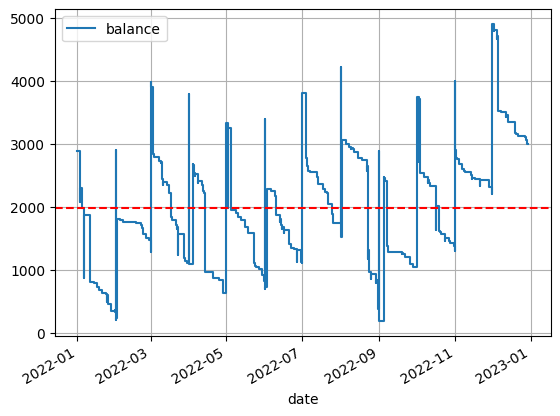

In [9]:
transactions.plot(clm['date'], clm['balance'], drawstyle='steps-post')
plt.axhline(y=transactions.set_index(clm['date']).resample('1D').mean(numeric_only=True).interpolate(method='pad').mean()[clm['balance']], color='r', linestyle='--')
plt.grid()

balance = ( transactions.iloc[-1][clm['amount' ]]
          + transactions.iloc[ 0][clm['balance']]
          - transactions.iloc[-1][clm['balance']] )
print(f"Balance over time: { round( balance , 2) } €")

print(f"Current balance:   { transactions.iloc[0][clm['balance']] } €")

- sunburst all categories

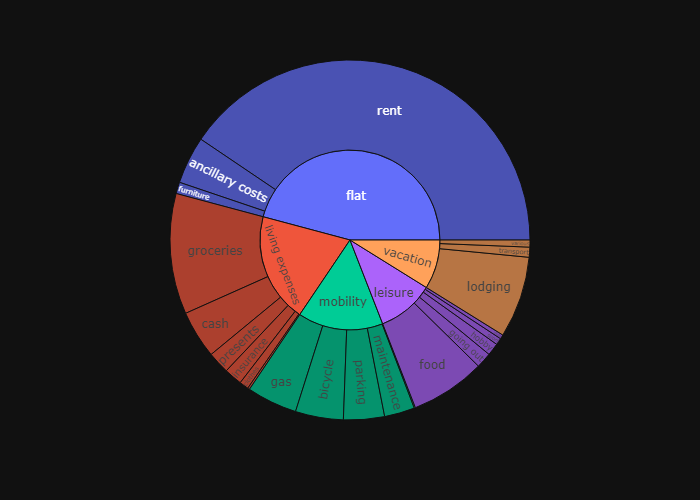

Total spendings: 29597 €


In [10]:
fig = px.sunburst(df_sunburst, path=[clm['category'], clm['cat_fine']], values=clm['sum'], template="plotly_dark")
# fig.show()
fig.show('png')

print(f"Total spendings: {int(df_sunburst[clm['sum']].sum())} €")

- all categories per month

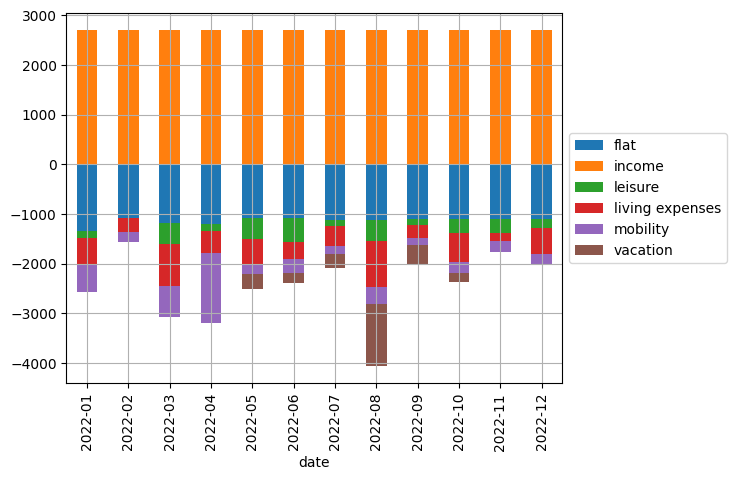

In [11]:
df_plot_rough.plot.bar(stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.grid()

- saldo per month

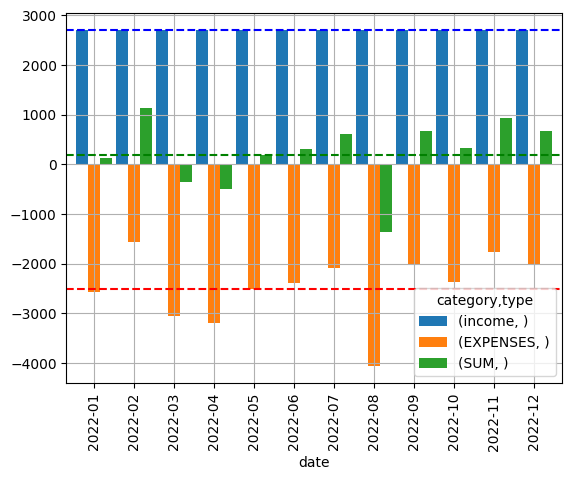

In [12]:
df_plot_fine.plot.bar(y=[ ('income','') , (clm['expenses'],'') , (clm['sum'],'') ] , width=0.9)
plt.axhline(y=sum_cat_month.loc[('income','')        , clm['mean_month']], color='b', linestyle='--')
plt.axhline(y=sum_cat_month.loc[(clm['expenses'],'') , clm['mean_month']], color='r', linestyle='--')
plt.axhline(y=sum_cat_month.loc[(clm['sum'],'')      , clm['mean_month']], color='g', linestyle='--')
plt.grid()

- individual categories per month

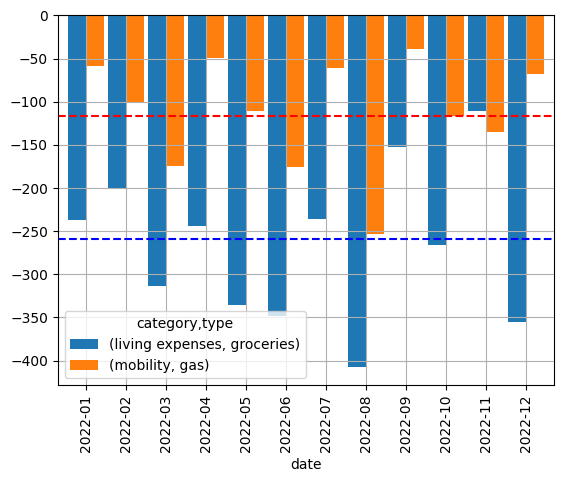

In [13]:
df_plot_fine.plot.bar(y=[ ('living expenses','groceries') , ('mobility','gas') ], width=0.9)
plt.axhline(y=sum_cat_month.loc[ ('living expenses','groceries') , clm['mean_month'] ], color='b', linestyle='--')
plt.axhline(y=sum_cat_month.loc[ ('mobility','gas')              , clm['mean_month'] ], color='r', linestyle='--')
plt.grid()